In [1]:
# input_dir = '/kaggle/input'
# output_dir = '/kaggle/working'
input_dir = '.'
output_dir = './data'

In [2]:
import pandas as pd
import numpy as np
import os

df_mobile_raw = pd.read_csv(os.path.join(input_dir, "mobile-price-classification/train.csv"))
df_mobile_desc = pd.read_csv(os.path.join(input_dir, "mobile-price-classification/desc.csv"))

df_housing_raw = pd.read_csv(os.path.join(input_dir, "housing-price-prediction/Housing.csv"))
df_housing_desc = pd.read_csv(os.path.join(input_dir, "housing-price-prediction/desc.csv"))

df_students_raw = pd.read_csv(os.path.join(input_dir, "student-performance-data/student_data.csv"))
df_students_desc = pd.read_csv(os.path.join(input_dir, "student-performance-data/desc.csv"))

df_mobile_raw = df_mobile_raw.sample(512, random_state=42).reset_index(drop=True)

In [3]:
from sklearn import preprocessing
from itertools import chain


def binarize_boolean(name, df, cols):
    for col in cols:
        numerical, categories = pd.factorize(df[col], sort=True)
        df[col] = numerical


def binarize_categorical(name, df, cols):
    dummies = {}
    for col in cols:
        df_dummies = pd.get_dummies(df.pop(col), prefix=col).astype(np.float64)
        dummies_names = df_dummies.columns.tolist()
        dummies[col] = dummies_names
        df.loc[:, dummies_names] = df_dummies
    return list(chain(*dummies.values()))


def binarize_numeric(name, df, cols):
    scaler = preprocessing.StandardScaler()
    df.loc[:, cols] = scaler.fit_transform(df.loc[:, cols])


def info(df_data, df_desc):
    df_info = pd.DataFrame({
        "name": df_data.columns, 
        "non-nulls": (~df_data.isnull()).sum().values, 
        "nulls": df_data.isnull().sum().values,
    })
    return pd.merge(df_info, df_desc, left_on='name', right_on='colname')

# Mobile price prediction

In [4]:
with pd.option_context('display.max_colwidth', 400):
    display(info(df_mobile_raw, df_mobile_desc))

,name,non-nulls,nulls,colname,description
0,battery_power,512,0,battery_power,Total energy a battery can store in one time measured in mAh
1,blue,512,0,blue,Has bluetooth or not
2,clock_speed,512,0,clock_speed,speed at which microprocessor executes instructions
3,dual_sim,512,0,dual_sim,Has dual sim support or not
4,fc,512,0,fc,Front Camera mega pixels
5,four_g,512,0,four_g,Has 4G or not
6,int_memory,512,0,int_memory,Internal Memory in Gigabytes
7,m_dep,512,0,m_dep,Mobile Depth in cm
8,mobile_wt,512,0,mobile_wt,Weight of mobile phone
9,n_cores,512,0,n_cores,Number of cores of processor


In [5]:
mobile_target_variable = "price_range"
mobile_bool_columns = ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]
mobile_float_columns = ['clock_speed', 'm_dep']
mobile_int_columns = ['battery_power', 'fc', 'int_memory', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']

for attr in mobile_bool_columns:
    assert sorted(df_mobile_raw[attr].unique().tolist()) == [0,1]
    
X_mobile_cols = mobile_bool_columns + mobile_float_columns + mobile_int_columns
print(len(X_mobile_cols))

assert all(col in df_mobile_raw.columns for col in X_mobile_cols + [mobile_target_variable])

20


In [6]:
df_mobile = df_mobile_raw.copy()
binarize_numeric("mobile", df_mobile, mobile_int_columns + mobile_float_columns)

In [7]:
df_mobile['price_range'] = (df_mobile['price_range'] >= 2).astype(int) # pd.qcut(df_mobile.price_range, 2, labels=False)

In [8]:
with pd.option_context('display.max_columns', 400):
    display(df_mobile.head())

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0.953345,0,1.204554,0,-0.312070,1,-0.350311,0.362785,1.728336,-1.102943,-0.797364,-1.001292,0.810647,-1.323867,-1.078624,-0.008117,-0.053982,1,1,0,0
1,-0.117346,0,-1.285279,0,0.608851,1,-1.294599,0.019447,-0.022112,1.556587,0.976235,-0.856743,-0.613372,0.391184,1.537574,2.531515,1.439995,1,0,0,1
2,1.705597,0,1.702520,0,1.069311,0,-0.961321,-0.323891,1.615404,1.113332,1.298708,-0.816088,-0.691212,-0.748224,-1.078624,-1.162495,-0.614223,1,1,0,0
3,-0.562698,1,0.582096,0,-0.081840,0,-0.794682,-1.010568,0.768413,-0.659688,1.459944,-0.899656,0.320711,1.605518,1.299737,0.222759,1.439995,1,1,0,1
4,-1.425711,1,-1.285279,1,0.608851,0,1.482719,0.019447,-0.247976,0.226822,-0.313655,0.828158,1.611944,-0.209129,0.348393,-0.238992,-1.174464,1,0,0,0


# Housing Price Prediction

In [9]:
with pd.option_context('display.max_colwidth', 400):
    display(info(df_housing_raw, df_housing_desc))

,name,non-nulls,nulls,colname,description
0,price,545,0,price,The price of the house.
1,area,545,0,area,The total area of the house in square feet.
2,bedrooms,545,0,bedrooms,The number of bedrooms in the house.
3,bathrooms,545,0,bathrooms,The number of bathrooms in the house.
4,stories,545,0,stories,The number of stories in the house.
5,mainroad,545,0,mainroad,Whether the house is connected to the main road (Yes/No).
6,guestroom,545,0,guestroom,Whether the house has a guest room (Yes/No).
7,basement,545,0,basement,Whether the house has a basement (Yes/No).
8,hotwaterheating,545,0,hotwaterheating,Whether the house has a hot water heating system (Yes/No).
9,airconditioning,545,0,airconditioning,Whether the house has an air conditioning system (Yes/No).


In [10]:
housing_bool_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
housing_int_cols = ["area", "bedrooms", "bathrooms", "stories", "parking"]
housing_cat_cols = ["furnishingstatus"]

X_housing_cols = housing_bool_cols + housing_int_cols + housing_cat_cols
print(len(X_housing_cols))

assert all(col in df_housing_raw.columns for col in X_housing_cols)

for cat in housing_cat_cols:
    print(cat, df_housing_raw[cat].unique())

12
furnishingstatus ['furnished' 'semi-furnished' 'unfurnished']


In [11]:
df_housing = df_housing_raw.copy()
binarize_numeric("housing", df_housing, housing_int_cols)
binarize_boolean("housing", df_housing, housing_bool_cols)
housing_cat_cols = binarize_categorical("housing", df_housing, housing_cat_cols)

X_housing_cols = housing_bool_cols + housing_int_cols + housing_cat_cols
print(len(X_housing_cols))

14


In [12]:
df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,1.046726,1.403419,1.421812,1.378217,1,0,0,0,1,1.517692,1,1.0,0.0,0.0
1,12250000,1.757010,1.403419,5.405809,2.532024,1,0,0,0,1,2.679409,0,1.0,0.0,0.0
2,12250000,2.218232,0.047278,1.421812,0.224410,1,0,1,0,0,1.517692,1,0.0,1.0,0.0
3,12215000,1.083624,1.403419,1.421812,0.224410,1,0,1,0,1,2.679409,1,1.0,0.0,0.0
4,11410000,1.046726,1.403419,-0.570187,0.224410,1,1,1,0,1,1.517692,0,1.0,0.0,0.0


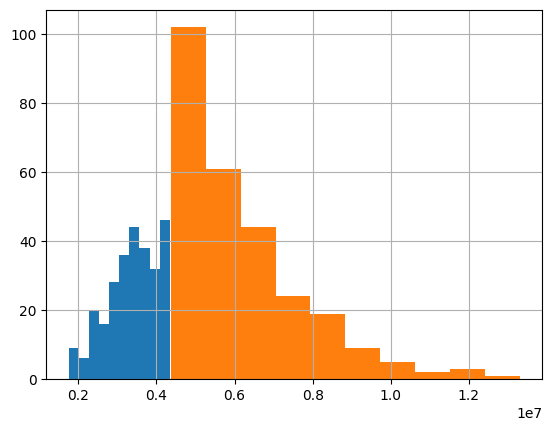

In [13]:
df_housing['price_range'] = pd.qcut(df_housing.price, 2, labels=False)
housing_target_variable = "price_range"

for i in range(2):
    df_housing[df_housing.price_range == i].price.hist()

# Student Performance Dataset

In [14]:
with pd.option_context('display.max_colwidth', 400):
    display(info(df_students_raw, df_students_desc))

,name,non-nulls,nulls,colname,description
0,school,395,0,school,Type of school
1,sex,395,0,sex,Gender of Student
2,age,395,0,age,Age of Student
3,address,395,0,address,Address of Student
4,famsize,395,0,famsize,Size of Family
5,Pstatus,395,0,Pstatus,Status of Parents
6,Medu,395,0,Medu,Education of Mother (ranked 1 to 5 )
7,Fedu,395,0,Fedu,Education of Father (ranked 1 to 5 )
8,Mjob,395,0,Mjob,occupation of Mother
9,Fjob,395,0,Fjob,occupation of Father


In [15]:
students_target_variable = "G3"
students_bool_cols = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
students_int_cols = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences"]
students_cat_cols = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian"]

X_students_cols = students_bool_cols + students_int_cols + students_cat_cols
print(len(X_students_cols))

assert all(col in df_students_raw.columns for col in X_students_cols + [students_target_variable])

for cat in students_cat_cols:
    print(cat, df_students_raw[cat].unique())

30
school ['GP' 'MS']
sex ['F' 'M']
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'services' 'health' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other']


Plus 3 targets - G1, G2, G3. To simplify, let's just predict G3

In [16]:
df_students = df_students_raw.copy()
binarize_numeric("students", df_students, students_int_cols)
binarize_boolean("students", df_students, students_bool_cols)
students_cat_cols = binarize_categorical("students", df_students, students_cat_cols)

X_students_cols = students_bool_cols + students_int_cols + students_cat_cols
print(len(X_students_cols))

assert all(col in df_students.columns for col in X_students_cols + [students_target_variable])

48


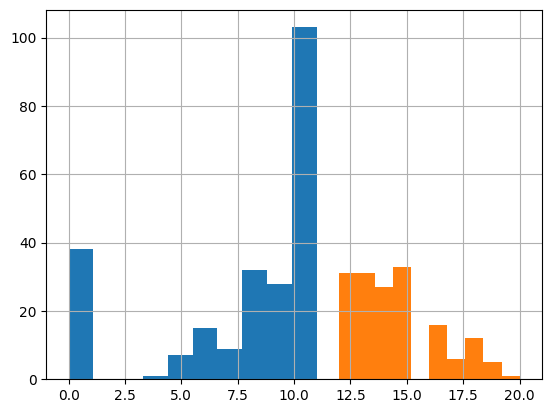

In [17]:
df_students['grade_range'] = pd.qcut(df_students["G3"], 2, labels=False)
students_target_variable = "grade_range"

for i in range(2):
    df_students[df_students["grade_range"] == i]["G3"].hist()

In [18]:
with pd.option_context('display.max_columns', 400):
    display(df_students.head())

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,grade_range
0,1.023046,1.143856,1.360371,0.792251,-0.042286,-0.449944,1,0,0,0,1,1,0,0,0.062194,-0.236010,0.801479,-0.540699,-1.003789,-0.399289,0.036424,5,6,6,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.238380,-1.600009,-1.399970,-0.643249,-0.042286,-0.449944,0,1,0,0,0,1,1,0,1.178860,-0.236010,-0.097908,-0.540699,-1.003789,-0.399289,-0.213796,5,5,6,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.330954,-1.600009,-1.399970,-0.643249,-0.042286,3.589323,1,0,1,0,1,1,1,0,0.062194,-0.236010,-0.997295,0.583385,0.551100,-0.399289,0.536865,7,8,10,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,-1.330954,1.143856,-0.479857,-0.643249,1.150779,-0.449944,0,1,1,1,1,1,1,1,-1.054472,-1.238419,-0.997295,-0.540699,-1.003789,1.041070,-0.464016,15,14,15,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
4,-0.546287,0.229234,0.440257,-0.643249,-0.042286,-0.449944,0,1,1,0,1,1,0,0,0.062194,-0.236010,-0.997295,-0.540699,-0.226345,1.041070,-0.213796,6,10,10,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


In [19]:
X_mobile, y_mobile = df_mobile[X_mobile_cols], df_mobile[mobile_target_variable]
X_housing, y_housing = df_housing[X_housing_cols], df_housing[housing_target_variable]
X_students, y_students = df_students[X_students_cols], df_students[students_target_variable]

In [20]:
with pd.option_context('display.max_columns', 400):
    print("Target value counts")
    display(y_mobile.value_counts(), y_housing.value_counts(), y_students.value_counts())

Target value counts


1    260
0    252
Name: price_range, dtype: int64

0    275
1    270
Name: price_range, dtype: int64

0    233
1    162
Name: grade_range, dtype: int64

In [21]:
len(y_mobile.unique()), len(y_housing.unique()), len(y_students.unique())

(2, 2, 2)

In [22]:
# Model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [24]:
def run_for_all_ds(function, **kwargs):
    global X_mobile, X_housing, X_students, y_mobile, y_housing, y_students
    function(X_mobile, y_mobile, name="Mobile", **kwargs)
    function(X_housing, y_housing, name="Housing", **kwargs)
    function(X_students, y_students, name="Students", **kwargs)

## Naive Bayes

There's no meaningful parameters for it, so I won't do a grid search for Naive Bayes

In [25]:
classification_results = []

In [26]:
def cross_validation_scores(X_train, y_train, name, clf, clf_name):
    print(f"Cross validation scores for {clf_name.title()}:")
    print()
    scores = []
    for scoring in ['f1_macro', 'accuracy']:
        print(f"{name.title()} dataset: {' '.join(scoring.title().split('_'))}:")
        cv_score = cross_val_score(clf, X_train, y_train, scoring=scoring, cv=5)
        print(cv_score, cv_score.mean(), sep="\n")
        print()
        scores.append(cv_score.mean())
    classification_results.append(dict(
        classifier=clf_name.title(),
        dataset=name.title(),
        f1_macro=scores[0],
        accuracy=scores[1],
    ))

In [27]:
run_for_all_ds(cross_validation_scores, clf=GaussianNB(), clf_name="naive bayes")

Cross validation scores for Naive Bayes:

Mobile dataset: F1 Macro:
[0.94160998 0.97087379 0.91168831 0.9212963  0.91175622]
0.9314449191765488

Mobile dataset: Accuracy:
[0.94174757 0.97087379 0.91176471 0.92156863 0.91176471]
0.9315438796877974

Cross validation scores for Naive Bayes:

Housing dataset: F1 Macro:
[0.74822317 0.76265134 0.88057311 0.8421232  0.68405797]
0.7835257584417518

Housing dataset: Accuracy:
[0.76146789 0.7706422  0.88073394 0.8440367  0.70642202]
0.7926605504587156

Cross validation scores for Naive Bayes:

Students dataset: F1 Macro:
[0.54259719 0.77034884 0.54423077 0.56788932 0.56111111]
0.5972354446397956

Students dataset: Accuracy:
[0.55696203 0.7721519  0.5443038  0.56962025 0.56962025]
0.6025316455696202



##  Decision tree

In [28]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

@ignore_warnings(category=ConvergenceWarning)
def grid_search(X, y, name, clf, param_grid, clf_name, **kwargs):
    print(f"Grid search for {name} dataset")
    grid_search_clf = GridSearchCV(clf, 
                                   cv=5, 
                                   param_grid=param_grid,
                                   verbose=True,
                                   **kwargs)
    grid_search_clf.fit(X, y)
    print(clf_name.title(), "results:")
    print('Best Score: ' + str(grid_search_clf.best_score_))
    print('Best Parameters: ' + str(grid_search_clf.best_params_))
    print()
    clf = grid_search_clf.best_estimator_
    cross_validation_scores(X, y, name, clf, clf_name)
    print()

In [29]:
param_grid =  {
    'criterion': ['gini','entropy'],
    'splitter': ['best'],
    'max_depth': [3, 10, 20, 25],
    'max_features': ['sqrt', 3, 5, 10],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

In [30]:
run_for_all_ds(grid_search,
               clf=DecisionTreeClassifier(),
               param_grid=param_grid,
               clf_name="decision tree", 
               n_jobs=-1)

Grid search for Mobile dataset
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Decision Tree results:
Best Score: 0.9413097277746049
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'splitter': 'best'}

Cross validation scores for Decision Tree:

Mobile dataset: F1 Macro:
[0.93193618 0.96113208 0.93120725 0.88235294 0.8918971 ]
0.9197051092466904

Mobile dataset: Accuracy:
[0.89320388 0.95145631 0.88235294 0.89215686 0.92156863]
0.9081477251094613


Grid search for Housing dataset
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Decision Tree results:
Best Score: 0.7706422018348624
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'}

Cross validation scores for Decision Tree:

Housing dataset: F1 Macro:
[0.65433404 0.79773954 0.81637466 0.70351847 0.64065934]
0.7225252105440851

Housing datase

##  Random Forest

In [31]:
param_grid =  {
    'n_estimators': [100, 200, 500],
    'criterion':['gini','entropy'],
    'bootstrap': [True],
    'max_depth': [10, 20, 25],
    'max_features': ['sqrt', 3, 10],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3]
}

In [32]:
run_for_all_ds(grid_search,
               clf=RandomForestClassifier(random_state=42),
               param_grid=param_grid,
               clf_name="random forest", 
               n_jobs=-1)

Grid search for Mobile dataset
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Random Forest results:
Best Score: 0.9530553969160481
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}

Cross validation scores for Random Forest:

Mobile dataset: F1 Macro:
[0.9708628  0.97087379 0.94115385 0.93136595 0.95093795]
0.9530388672389056

Mobile dataset: Accuracy:
[0.97087379 0.97087379 0.94117647 0.93137255 0.95098039]
0.9530553969160481


Grid search for Housing dataset
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Random Forest results:
Best Score: 0.7669724770642202
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Cross validation scores for Random Forest:

Housing dataset: F1 Macro:
[0.6724342  0.86970628 0.83451417 0.76265

##  Logistic Regression

In [33]:
param_grid = {
    'max_iter' : [100, 500],
    'penalty' : ['l2'], 
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['lbfgs', 'liblinear']
}

In [34]:
run_for_all_ds(grid_search,
               clf = LogisticRegression(random_state=42),
               param_grid=param_grid,
               clf_name="Logistic Regression")

Grid search for Mobile dataset
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression results:
Best Score: 0.9921758994860082
Best Parameters: {'C': 1291.5496650148827, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Cross validation scores for Logistic Regression:

Mobile dataset: F1 Macro:
[0.99029126 1.         1.         0.97056277 1.        ]
0.9921708065397385

Mobile dataset: Accuracy:
[0.99029126 1.         1.         0.97058824 1.        ]
0.9921758994860082


Grid search for Housing dataset
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression results:
Best Score: 0.7944954128440368
Best Parameters: {'C': 2.782559402207126, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Cross validation scores for Logistic Regression:

Housing dataset: F1 Macro:
[0.73967271 0.81462585 0.89908257 0.81193927 0.65221471]
0.7835070227025873

Housing dataset: Accuracy:
[0.75229358 0.81651376 0.89908257 0.81651376 0.68807339]
0.794

## K-NN

In [35]:
param_grid = {
    'n_neighbors' : [1, 3, 5, 10, 50, 100],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree','kd_tree'],
#     'leaf_size': [10, 30, 100],
    'p' : [1, 2]
}

In [36]:
run_for_all_ds(grid_search,
               clf=KNeighborsClassifier(),
               param_grid=param_grid,
               clf_name="K Nearest Neighbors",
               n_jobs=-1)

Grid search for Mobile dataset
Fitting 5 folds for each of 72 candidates, totalling 360 fits
K Nearest Neighbors results:
Best Score: 0.9296021321149819
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 100, 'p': 1, 'weights': 'uniform'}

Cross validation scores for K Nearest Neighbors:

Mobile dataset: F1 Macro:
[0.951438   0.951438   0.91175622 0.92144782 0.91155217]
0.9295264446242235

Mobile dataset: Accuracy:
[0.95145631 0.95145631 0.91176471 0.92156863 0.91176471]
0.9296021321149819


Grid search for Housing dataset
Fitting 5 folds for each of 72 candidates, totalling 360 fits
K Nearest Neighbors results:
Best Score: 0.7688073394495413
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 50, 'p': 2, 'weights': 'uniform'}

Cross validation scores for K Nearest Neighbors:

Housing dataset: F1 Macro:
[0.78002983 0.84398417 0.87102772 0.7178938  0.53672037]
0.7499311787991918

Housing dataset: Accuracy:
[0.78899083 0.8440367  0.87155963 0.73394495 0.60550459]
0.7688073394495413


## CatBoost

In [37]:
param_grid = {
    'learning_rate': [0.001, 0.01],
    'depth': [5, 10],
    'min_child_samples': [2, 5],
    'iterations': [100],
    'logging_level': ['Silent'],
}

In [38]:
run_for_all_ds(grid_search,
              clf=CatBoostClassifier(
                    random_state=42, 
                    loss_function="MultiClass",
                    eval_metric="Accuracy"
                ),
               param_grid=param_grid,
               clf_name="CatBoost", 
               n_jobs=-1)

Grid search for Mobile dataset
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Catboost results:
Best Score: 0.929564058633162
Best Parameters: {'depth': 5, 'iterations': 100, 'learning_rate': 0.01, 'logging_level': 'Silent', 'min_child_samples': 2}

Cross validation scores for Catboost:

Mobile dataset: F1 Macro:
[0.95138299 0.9708628  0.92144782 0.8921465  0.91155217]
0.929478456520813

Mobile dataset: Accuracy:
[0.95145631 0.97087379 0.92156863 0.89215686 0.91176471]
0.929564058633162


Grid search for Housing dataset
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Catboost results:
Best Score: 0.7614678899082569
Best Parameters: {'depth': 5, 'iterations': 100, 'learning_rate': 0.01, 'logging_level': 'Silent', 'min_child_samples': 2}

Cross validation scores for Catboost:

Housing dataset: F1 Macro:
[0.63639733 0.82420847 0.88057311 0.73671498 0.65659748]
0.7468982744570456

Housing dataset: Accuracy:
[0.66972477 0.82568807 0.88073394 0.74311927 0.68807339]
0

## XGBoost

In [39]:
param_grid = {
    'n_estimators': [100], 
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

In [40]:
run_for_all_ds(grid_search,
               clf = XGBClassifier(random_state=42),
               param_grid=param_grid,
               clf_name="XGBoost", 
               n_jobs=-1)

Grid search for Mobile dataset
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Xgboost results:
Best Score: 0.9628022082619456
Best Parameters: {'colsample_bytree': 0.75, 'gamma': 1, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 2, 'sampling_method': 'uniform', 'subsample': 0.6}

Cross validation scores for Xgboost:

Mobile dataset: F1 Macro:
[0.98058069 0.99029126 0.94117647 0.94115385 0.96076923]
0.9627943006926444

Mobile dataset: Accuracy:
[0.98058252 0.99029126 0.94117647 0.94117647 0.96078431]
0.9628022082619456


Grid search for Housing dataset
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Xgboost results:
Best Score: 0.7889908256880734
Best Parameters: {'colsample_bytree': 0.75, 'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.55}

Cross validation scores for Xgboost:

Housing dataset: F1 Macro:
[0.75035236 0.85170068 0.86238532 0.77132867 

In [41]:
df = pd.DataFrame(classification_results)
df_results_mobile = df.drop(columns="dataset")[df.dataset == "Mobile"]
df_results_housing = df.drop(columns="dataset")[df.dataset == "Housing"]
df_results_students = df.drop(columns="dataset")[df.dataset == "Students"]

## Cross validation results after hyperparameter tuning

In [42]:
df_results_mobile.sort_values(by='f1_macro', ascending=False)

,classifier,f1_macro,accuracy
9,Logistic Regression,0.992171,0.992176
18,Xgboost,0.962794,0.962802
6,Random Forest,0.953039,0.953055
0,Naive Bayes,0.931445,0.931544
12,K Nearest Neighbors,0.929526,0.929602
15,Catboost,0.929478,0.929564
3,Decision Tree,0.919705,0.908148


In [43]:
df_results_housing.sort_values(by='f1_macro', ascending=False)

,classifier,f1_macro,accuracy
1,Naive Bayes,0.783526,0.792661
10,Logistic Regression,0.783507,0.794495
19,Xgboost,0.777596,0.788991
7,Random Forest,0.751659,0.766972
13,K Nearest Neighbors,0.749931,0.768807
16,Catboost,0.746898,0.761468
4,Decision Tree,0.722525,0.730275


In [44]:
df_results_students.sort_values(by='f1_macro', ascending=False)

,classifier,f1_macro,accuracy
20,Xgboost,0.599721,0.630380
2,Naive Bayes,0.597235,0.602532
14,K Nearest Neighbors,0.564667,0.622785
8,Random Forest,0.559067,0.632911
17,Catboost,0.543210,0.615190
11,Logistic Regression,0.529248,0.630380
5,Decision Tree,0.486537,0.592405
